In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/names.csv
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/anno_test.csv
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/anno_train.csv
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/04772.jpg
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/08033.jpg
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/03004.jpg
/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test/Dodge Ram Pickup 3500 Crew Cab 2010/06551.jpg
/kaggle/input/stanford-car-dataset-images-in-224x

In [2]:
trainpath = '/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/train'
testpath = '/kaggle/input/stanford-car-dataset-images-in-224x224/stanford-car-dataset-by-classes-folder-224/car_data/test'

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

tf.keras.mixed_precision.set_global_policy('mixed_float16')


In [27]:
batch_size = 32
img_size = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE


# DenseNet Model

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=.2,
    subset="training", 
    seed=123,  
    label_mode='categorical',
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    trainpath,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=.2,
    subset="validation", 
    seed=123,
    label_mode='categorical',
    shuffle=True
)

Found 8144 files belonging to 196 classes.
Using 6516 files for training.
Found 8144 files belonging to 196 classes.
Using 1628 files for validation.


In [30]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


Number of classes: 196
Class names: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6

In [31]:
normalization_layer = layers.Rescaling(1./255)

In [32]:
train_dataset = (train_dataset
                 .map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
                 .cache()
                 .shuffle(1000)
                 .prefetch(buffer_size=AUTOTUNE))

In [33]:
val_dataset = (val_dataset
               .map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
               .cache()
               .prefetch(buffer_size=AUTOTUNE))

In [34]:
print(f"Train batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")

Train batches: 204
Validation batches: 51


In [35]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers


model2 = DenseNet121(
    weights='imagenet',
    include_top=False, 
    input_shape=(224, 224, 3)
)

model2.trainable = True


for layer in model2.layers[:300]:  
    layer.trainable = False


Densenet_model = models.Sequential([
    model2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(196, activation='softmax') 
])


Densenet_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
Densenet_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 2,889,408 (11.02 MB)

 Non-trainable params: 4,148,096 (15.82 MB)

In [36]:
from keras.optimizers import Adam

Densenet_model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [37]:
Densenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 2,889,408 (11.02 MB)

 Non-trainable params: 4,148,096 (15.82 MB)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_xception_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')


history = Densenet_model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=15, 
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/15


I0000 00:00:1734557510.799945     101 service.cc:145] XLA service 0x7fece8003270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734557510.800005     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734557510.800010     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/204 ━━━━━━━━━━━━━━━━━━━━ 4:49:25 86s/step - accuracy: 0.0000e+00 - loss: 5.9377

I0000 00:00:1734557554.107931     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


204/204 ━━━━━━━━━━━━━━━━━━━━ 161s 374ms/step - accuracy: 0.0045 - loss: 5.7329 - val_accuracy: 0.0055 - val_loss: 5.5040
Epoch 2/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.0094 - loss: 5.3726 - val_accuracy: 0.0166 - val_loss: 5.2830
Epoch 3/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.0306 - loss: 5.0607 - val_accuracy: 0.0270 - val_loss: 5.0986
Epoch 4/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.0670 - loss: 4.7934 - val_accuracy: 0.0448 - val_loss: 4.9363
Epoch 5/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.1154 - loss: 4.5389 - val_accuracy: 0.0682 - val_loss: 4.7926
Epoch 6/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.1812 - loss: 4.3368 - val_accuracy: 0.0885 - val_loss: 4.6589
Epoch 7/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.2494 - loss: 4.1184 - val_accuracy: 0.1081 - val_loss: 4.5373
Epoch 8/15
204/204 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.3037 - loss: 3.9536 - val_accur

In [42]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    testpath,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 8041 files belonging to 196 classes.


In [43]:
test_dataset = (test_dataset
                .map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
                .cache()
                .prefetch(buffer_size=AUTOTUNE))

In [46]:
test_loss, test_accuracy = Densenet_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.4842 - loss: 2.5401
Test Accuracy: 49.24%


In [47]:
history = Densenet_model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=30, 
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.9995 - loss: 0.4598 - val_accuracy: 0.5068 - val_loss: 2.5377
Epoch 2/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.9992 - loss: 0.4256 - val_accuracy: 0.5092 - val_loss: 2.5141
Epoch 3/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.9997 - loss: 0.3950 - val_accuracy: 0.5104 - val_loss: 2.5005
Epoch 4/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.9996 - loss: 0.3664 - val_accuracy: 0.5135 - val_loss: 2.4790
Epoch 5/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.9997 - loss: 0.3406 - val_accuracy: 0.5172 - val_loss: 2.4624
Epoch 6/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.9999 - loss: 0.3169 - val_accuracy: 0.5172 - val_loss: 2.4441
Epoch 7/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 1.0000 - loss: 0.2901 - val_accuracy: 0.5197 - val_loss: 2.4268
Epoch 8/30
204/204 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 1.0000 - loss: 0.2669 - 

In [48]:
Densenet_model.load_weights('/kaggle/working/best_xception_model.keras')


In [49]:
test_loss, test_accuracy = Densenet_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.5285 - loss: 2.1590
Test Accuracy: 53.18%


In [50]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.show()


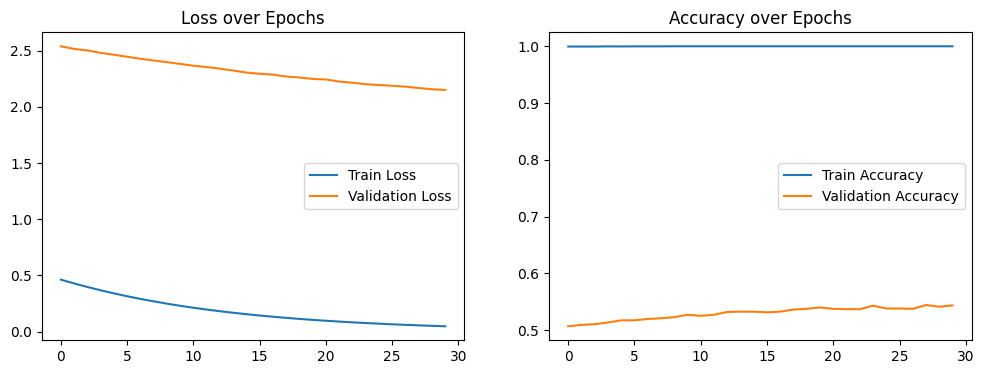

In [51]:
plot_history(history)

In [53]:
import numpy as np
Y_pred = Densenet_model.predict(test_dataset)
y_pred = np.argmax(Y_pred, axis=1)
y_true = []
for _, labels in test_dataset:
    y_true.extend(labels.numpy()) 

y_true_one_hot = np.array(y_true)


252/252 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step


In [54]:
if len(y_true_one_hot.shape) > 1 and y_true_one_hot.shape[1] > 1:
    y_true = np.argmax(y_true_one_hot, axis=1)


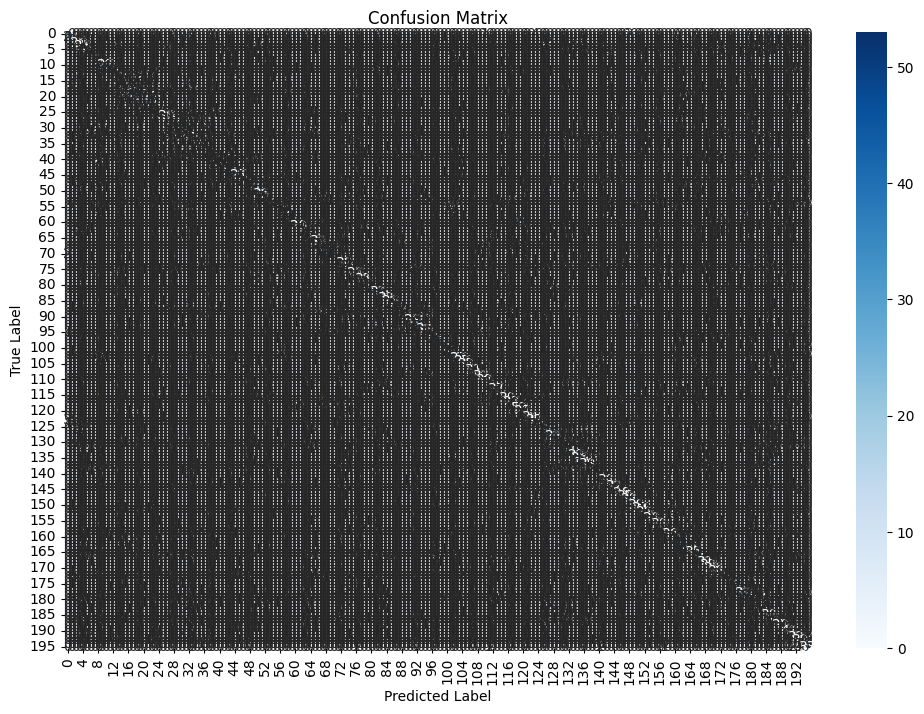

In [55]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [56]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


Classification Report:
                                                         precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.84      0.84      0.84        44
                             Acura Integra Type R 2001       0.56      0.50      0.53        44
                                   Acura RL Sedan 2012       0.17      0.12      0.15        32
                                   Acura TL Sedan 2012       0.42      0.60      0.50        43
                                  Acura TL Type-S 2008       0.52      0.67      0.58        42
                                  Acura TSX Sedan 2012       0.42      0.45      0.43        40
                              Acura ZDX Hatchback 2012       0.38      0.28      0.32        39
              Aston Martin V8 Vantage Convertible 2012       0.32      0.33      0.33        45
                    Aston Martin V8 Vantage Coupe 2012       0.30      0.44      0.36        41
               

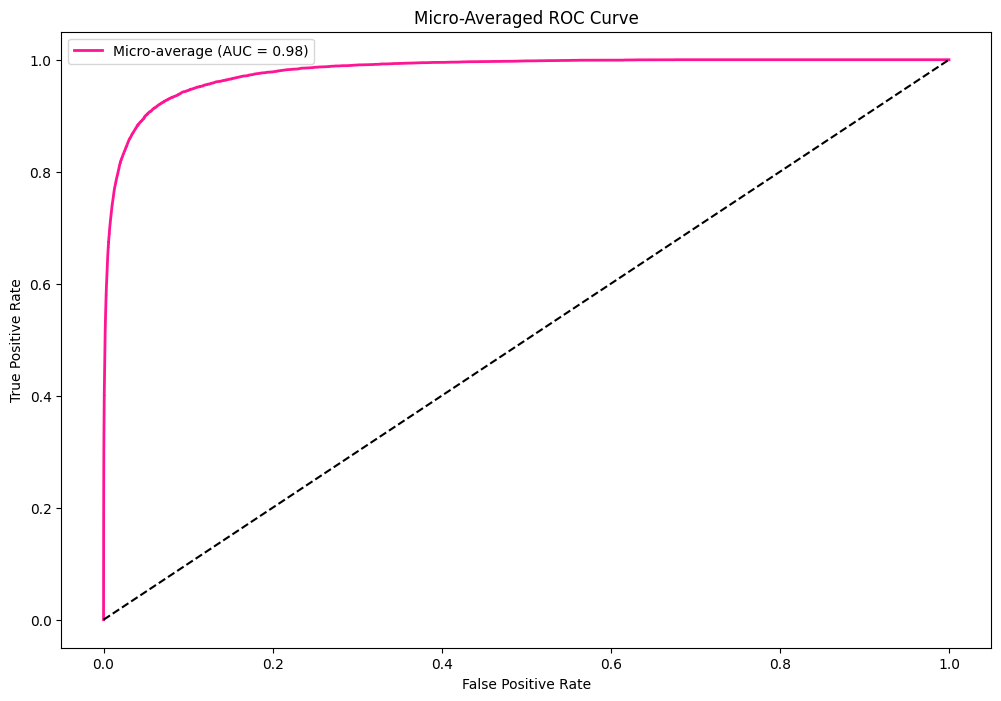

In [57]:
fpr = {}
tpr = {}
roc_auc = {}

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_one_hot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Averaged ROC Curve')
plt.legend()
plt.show()


# Densenet